In [1]:
import os, importlib, sys, time

In [2]:
import numpy as np
import scipy.sparse as sparse
import matplotlib.pyplot as plt
import pandas as pd
import pyarrow
from tqdm import tqdm

In [3]:
data_dir = '~/2010_0760_Data/Data/Raw_csv/' # directory to "2010-0760_Data/Data/Raw_csv"

# preprocess by Khatami et al.

In [4]:
def read_survey(data_dir):
    names = ['hhid', 'ppid', 'age', 'education', 'village native', 'caste',
        'subcaste', 'work', 'occupation', 'work for private or public',
        'work outside or not', 'SHG/saving group', 'Loan', 'Savings', 'Election Card', 'Ration Card', 'Ration Card Color']
    file_list = os.listdir(data_dir)
    file_list.sort()
    data = pd.DataFrame()
    for file in file_list:
        if 'survey' in file:
            df = pd.read_csv(data_dir+file,header=None,names=names)
            data = pd.concat([data,df],sort=False,ignore_index=True)
    data['id'] = [str(data.loc[i,'hhid'])+str(data.loc[i,'ppid']) if len(str(data.loc[i,'ppid']))>1
                  else str(data.loc[i,'hhid'])+'0'+str(data.loc[i,'ppid'])
                  for i in data.index ]
    data.set_index('id',inplace=True)
    return data

In [5]:
def read_village_info(data_dir):
    names = ['hhid', 'ppid', 'gender','age']
    file_list = os.listdir(data_dir)
    file_list.sort()
    data = pd.DataFrame()
    for file in file_list:
        if 'village' in file:
            df = pd.read_csv(data_dir+file,header=None,names=names)
            df['village'] = [file.replace('village','').replace('.csv','') for i in range((df.shape[0]))]
            data = pd.concat([data,df],sort=False,ignore_index=True)
    data['id'] = [str(data.loc[i,'hhid'])+str(data.loc[i,'ppid']) if len(str(data.loc[i,'ppid']))>1
                     else str(data.loc[i,'hhid'])+'0'+str(data.loc[i,'ppid'])
                     for i in data.index ]
    data.set_index(['id'],inplace=True)
    data.drop(columns=['hhid','ppid','age'],inplace=True)
    return data

In [6]:
def preprocess_survey(survey_data):
    survey_data.replace(to_replace=[-999.,-888.], value=np.nan, inplace=True)
    survey_data['education'].replace(to_replace=[16], value=np.nan, inplace=True)
    survey_data.replace({ col_name: 2.0 for col_name in ['village native','work','work outside or not','SHG/saving group','Loan','Savings','gender']},
                          0, inplace=True)
    survey_data.replace({ col_name: 3.0 for col_name in ['Election Card','Ration Card']},
                          0, inplace=True)
    survey_data.replace({ col_name: 16.0 for col_name in ['education']},
                          np.nan, inplace=True)
    survey_data_dummified = pd.get_dummies(survey_data,
                                       dummy_na=False, columns=['village native', 'caste',
                                                                'work',
                                                                'work for private or public',
                                                                'work outside or not',
                                                                'SHG/saving group', 'Loan',
                                                                'Savings', 'Election Card',
                                                                'Ration Card Color','gender'], sparse=False, drop_first=True, dtype=None)
   
    survey_data_dummified = survey_data_dummified.drop(columns=['ppid','occupation','subcaste','caste_6.0','caste_7.0','caste_11.0',
                                                                'caste_14.0','caste_17.0', 'caste_19.0','work for private or public_4.0',
                                                                'Ration Card','Election Card_2.0','Ration Card Color_4.0',
                                                               'Ration Card Color_5.0','Ration Card Color_6.0','village','hhid'])
    return survey_data_dummified.fillna(0)

In [7]:
def read_network(data_dir, survey_data):
    network_of_interest = ['nonrel','visitcome','visitgo','templecompany','rel','lendmoney','keroricecome']
    file_list = os.listdir(data_dir)
    networks = { s:pd.DataFrame() for s in network_of_interest}
    for file in tqdm(file_list):
        if np.max([(ni in file) for ni in network_of_interest])>0:
            df = pd.read_csv(data_dir+file,header=None,names=['ppid']+['n%d'%(i) for i in range(8)])
            df = df.astype(str)
            df = df.rename(columns={'ppid':'id'}).set_index('id')
            net_type = network_of_interest[np.argmax([(ni in file) for ni in network_of_interest])]
            v_idx = file.replace('.csv','').replace(net_type,'')
            df['village'] = [v_idx for i in range(df.shape[0])]
    #         print((net_type,v_idx))
            data = networks[net_type]
            data = pd.concat([data,df],sort=False)
            networks[net_type] = data

    social = pd.DataFrame(np.zeros((survey_data.shape[0],survey_data.shape[0])),index=survey_data.index,columns=survey_data.index)
    for net_type in tqdm(network_of_interest):
        df = networks[net_type].copy(deep=True)
        df = df.drop(columns=['village'])
        for idx in df.index:
            adj_list = set(df.loc[idx])
            for n in adj_list:
                try:
                    if n!='0':
                        social.loc[idx,n] = social.loc[idx,n]+1
                        social.loc[n,idx] = social.loc[n,idx]+1
                except:
                    continue
    social_b = (social>0).astype(int)
    return social, social_b 

## - read network

In [33]:
social, social_b = read_network(data_dir, survey_preprocessed)

100%|██████████████████████████████████████████████████████████████████| 7/7 [02:06<00:00, 18.06s/it]


In [34]:
social.shape

(16995, 16995)

In [35]:
social_b.shape

(16995, 16995)

## - read feature

In [8]:
survey_data = read_survey(data_dir)

In [9]:
survey_data

,hhid,ppid,age,education,village native,caste,subcaste,work,occupation,work for private or public,work outside or not,SHG/saving group,Loan,Savings,Election Card,Ration Card,Ration Card Color
id,,,,,,,,,,,,,,,,,
100201,1002,1,38,2,1,3.0,2,1.0,13.0,2.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0
100202,1002,2,27,2,2,3.0,2,2.0,NaN,NaN,NaN,2.0,2.0,2.0,1.0,1.0,1.0
100601,1006,1,29,7,1,3.0,2,1.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0
100602,1006,2,24,10,2,3.0,2,1.0,15.0,2.0,2.0,1.0,2.0,1.0,1.0,3.0,NaN
100701,1007,1,58,10,1,3.0,2,1.0,1.0,2.0,2.0,2.0,1.0,2.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919302,9193,2,30,12,1,1.0,1,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
919601,9196,1,65,5,1,1.0,31,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
919602,9196,2,50,16,1,3.0,31,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
village_data = read_village_info(data_dir)

In [13]:
village_data

,gender,village
id,,
100101,1,1
100102,2,1
100103,1,1
100104,2,1
100201,1,1
...,...,...
920604,2,9
920605,2,9
920606,2,9


In [14]:
merged_data = pd.merge(survey_data, village_data, on="id")

# additional preprocess

## - reduce feature

In [392]:
reduced_data = merged_data[["village", "hhid", "age", "education", "village native", "work", "work outside or not", "Savings", "SHG/saving group", "Loan"]]

In [393]:
reduced_data.columns = ['village', 'hhid', 'age', 'educ', 'native', 'work', 'outside', 'saving', 'shg', 'loan']

In [397]:
idx_srt = np.sort(reduced_data.loc[~np.isnan(reduced_data.loan)].index.astype(int)).astype(str)

In [398]:
reduced_data = reduced_data.reindex(idx_srt, axis=0)

In [403]:
reduced_data['educ'] = reduced_data.educ.fillna(0)
reduced_data.loc[reduced_data.educ == 15., 'educ'] = 14.

In [413]:
reduced_data = reduced_data.fillna(0)

In [430]:
reduced_data[['village','educ','work','outside','saving','shg','loan']] \
= reduced_data[['village','educ','work','outside','saving','shg','loan']].astype(int)

In [431]:
reduced_data

,village,hhid,age,educ,native,work,outside,saving,shg,loan
id,,,,,,,,,,
100201,1,1002,38,2,1,1,1,0,0,0
100202,1,1002,27,2,0,0,0,0,0,0
100601,1,1006,29,7,1,1,0,0,0,0
100602,1,1006,24,10,0,1,0,1,1,0
100701,1,1007,58,10,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
7516602,75,75166,32,11,0,0,0,1,1,1
7516701,75,75167,45,9,1,1,0,0,0,1
7516702,75,75167,32,9,0,0,0,1,1,1


## - reduce network

In [420]:
reduced_adj = social_b.reindex(idx_srt, axis=0).reindex(idx_srt, axis=1)

In [421]:
reduced_adj

id,100201,100202,100601,100602,100701,100702,100801,100802,100805,100806,...,7516002,7516004,7516301,7516302,7516601,7516602,7516701,7516702,7516801,7516802
id,,,,,,,,,,,,,,,,,,,,,
100201,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100202,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100601,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100602,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100701,0,0,0,1,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7516602,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
7516701,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,0
7516702,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,1,0,0,1


In [436]:
degree = np.sum(reduced_adj.values, 0)

(array([7.200e+01, 2.950e+02, 5.760e+02, 9.400e+02, 1.021e+03, 1.114e+03,
        9.610e+02, 9.320e+02, 7.860e+02, 6.240e+02, 5.230e+02, 4.010e+02,
        2.970e+02, 2.480e+02, 1.860e+02, 1.120e+02, 1.050e+02, 6.400e+01,
        5.700e+01, 3.500e+01, 3.400e+01, 1.800e+01, 9.000e+00, 6.000e+00,
        5.000e+00, 3.000e+00, 6.000e+00, 5.000e+00, 1.000e+00, 3.000e+00,
        1.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
        10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5,
        21.5, 22.

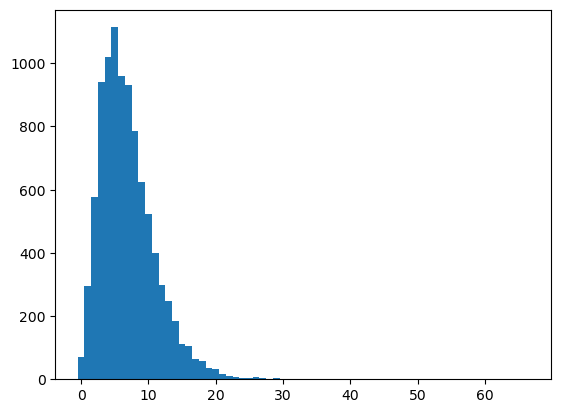

In [437]:
plt.hist(degree, np.arange(np.max(degree)+1)-0.5)

In [422]:
row, col = np.where(reduced_adj != 0)

In [423]:
reduced_network = pd.DataFrame({'row': row+1, 'col': col+1})

In [451]:
reduced_data.groupby('village').mean()

,hhid,age,educ,native,work,outside,saving,shg,loan
village,,,,,,,,,
1,1092.123077,41.210256,4.728205,0.574359,0.687179,0.102564,0.215385,0.102564,0.246154
2,2087.894472,37.547739,6.020101,0.603015,0.577889,0.256281,0.165829,0.155779,0.110553
3,3137.525223,39.765579,5.026706,0.537092,0.632047,0.234421,0.261128,0.243323,0.278932
4,4111.487903,38.983871,4.508065,0.520161,0.645161,0.241935,0.217742,0.221774,0.262097
12,12080.459893,39.165775,4.566845,0.550802,0.593583,0.262032,0.443850,0.368984,0.652406
19,19096.172566,37.265487,4.615044,0.623894,0.650442,0.181416,0.318584,0.216814,0.659292
21,21090.485294,37.661765,4.186275,0.598039,0.647059,0.230392,0.343137,0.215686,0.534314
23,23111.838057,41.165992,4.935223,0.574899,0.582996,0.170040,0.396761,0.206478,0.647773
24,24081.751244,40.527363,4.805970,0.601990,0.606965,0.174129,0.333333,0.164179,0.492537


# save data

In [412]:
save_dir = 'data'

In [432]:
reduced_data.to_feather('%s/feature.feather'%save_dir)

In [424]:
reduced_network.to_feather('%s/network.feather'%save_dir)